# _Moneyballing Fantasy Premier League Football_
# XGBoost

Random forests gave a slight improvement in performance (though not a huge amount - we still struggle with overfitting).

Can XGBoost do better?

### Bringing in the required libraries...

In [41]:
#Standard data manipulations
import pandas as pd
import numpy as np

#For data pre-processing
from sklearn.model_selection import train_test_split

#XGB
import xgboost as xgb

#Grid searching
from sklearn.model_selection import GridSearchCV

#Model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#Data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Import custom visuals settings
from PythonFunctions.cb91visuals import *

#Pickle!
import pickle

#Suppress warnings from showing
import warnings
warnings.filterwarnings('ignore')

... and the data

In [42]:
key_features=['Last4TotalShots',
 'Last4ShotsInBox',
 'Last4CloseShots',
 'OppLast4HeadersConceded',
 'Last4HACloseShots',
 'Last4HAShotInBoxCreated',
 'OppLast4HAShotsCentreConceded',
 'Last4RelativeStrength',
 'OppLast4HAShotsInBoxConceded',
 'OppLast4HAShotsRightConceded',
 'OppLast4HAClearances',
 'OppLast4HARelativeStrength',
 'Last4HAMinutes',
 'OppLast4HAPossession',
 'OppLast4HAGoalsConceded',
 'Last4HAShotsInBox',
 'Last4Minutes',
 'Last4ShotsOnTarget',
 'Last4HATotalShots',
 'OppLast4HATackles',
 'LastShotsInBox',
 'Last4HACloseShotCreated',
 'OppLast4RelativeStrength',
 'OppLast4HATouches',
 'Last4HAGoals',
 'Last4ShotsCentre',
 'OppLast4HAShotsConceded',
 'Last4HATotalShotCreated',
 'OppLast4Tackles',
 'OppLast4HAHeadersConceded',
 'OppLast4HAOffsides',
 'Last4Goals',
 'Last4CloseShotCreated',
 'Last4HARelativeStrength',
 'Last4HAShotsCentre',
 'OppLast4HACorners',
 'OppLast4Clearances',
 'LastShotsRight',
 'OppLast4HAShotsLeftConceded',
 'LastShotsCentre']

In [43]:
features = pd.read_csv('Data/Datasets/df_features_p.csv', index_col='Unnamed: 0')
y = pd.read_csv('Data/Datasets/df_targets_p.csv', index_col='Unnamed: 0')

XG = y['XG']
XA = y['XA']
XGI = y['XGI']

#Create test/train splits as required
X_train_XG, X_test_XG, y_train_XG, y_test_XG = train_test_split(features,XG,random_state=11)
X_train_XA, X_test_XA, y_train_XA, y_test_XA = train_test_split(features,XG,random_state=2)
X_train_XGI, X_test_XGI, y_train_XGI, y_test_XGI = train_test_split(features,XG,random_state=130)

Recall the performance functions we created in the last notebook...

In [44]:
def adj_r2(y_true, y_pred, n_feat=len(features.columns)):
    '''
    Takes true ys, predicted ys, the number of samples,
    and the number of variables.
    Calculates adjusted r squared
    '''
    n_samp = len(y_true)
    
    #Calculate regular r2
    R2 = r2_score(y_true, y_pred)
    
    #Return adjusted rsquared
    return 1-(1-R2)*(n_samp-1)/(n_samp-n_feat-1)



def plot_model(y_true, y_pred, title=None, size=(6,6)):
    '''
    Plots y_true against y_pred
    '''
    #Plot the scatter
    plt.figure(figsize=size)
    plt.scatter(y_true, y_pred, s=10, alpha=0.5)
    
    #Plot x=y
    max_val = max([y_true.max(), y_pred.max()])
    plt.plot([0,max_val],[0,max_val],color='red',lw=1,ls='--')

    plt.xlim(0)
    plt.ylim(0)

    plt.xlabel('Actual')
    plt.ylabel('Prediction')
    plt.title(title);
    


def performance(model, X_train, X_test, y_train, y_test, size=(4,4)):
    
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)
    
    print('\n_________R2_________\n')
    print('Train R2:', round(r2_score(y_train, y_hat_train),4))
    print('Test R2:', round(r2_score(y_test, y_hat_test),4))
    print('\nTrain Adj R2:', round(adj_r2(y_train, y_hat_train),4))
    print('Test Adj R2:', round(adj_r2(y_test, y_hat_test),4))
    
    print('\n_________MSE________\n')
    print('Train MSE:', round(mean_squared_error(y_train, y_hat_train),4))
    print('Test MSE:', round(mean_squared_error(y_test, y_hat_test),4))
    print('\nTrain RMSE:', round(mean_squared_error(y_train, y_hat_train)**0.5,4))
    print('Test RMSE:', round(mean_squared_error(y_test, y_hat_test)**0.5,4))

    plot_model(y_train, y_hat_train, title='Training Set', size=size)
    
    plot_model(y_test, y_hat_test, title='Test Set', size=size)

## Vanilla XGB

Let's get straight to a vanilla version of the xgb classifier, and see how it does.


_________R2_________

Train R2: 0.5124
Test R2: 0.1848

Train Adj R2: 0.5001
Test Adj R2: 0.1198

_________MSE________

Train MSE: 0.0494
Test MSE: 0.0859

Train RMSE: 0.2224
Test RMSE: 0.2932


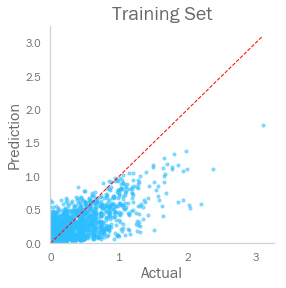

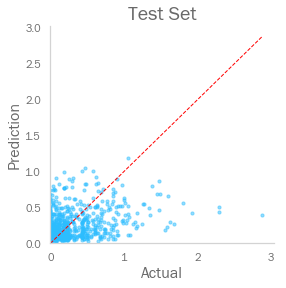

In [45]:
XG_xgb_1 = xgb.XGBRegressor(objective='reg:squarederror')
XG_xgb_1.fit(X_train_XG, y_train_XG)
performance(XG_xgb_1, X_train_XG, X_test_XG, y_train_XG, y_test_XG)

In [46]:
list(pd.DataFrame([features.columns,
              XGI_xgb_1.feature_importances_]).T.sort_values(
    1,ascending=False).head(40)[0])

['LastMinutes',
 'LastGoals',
 'LastRelativeStrength',
 'LastShotsOnTarget',
 'LastShotsRight',
 'LastCreatedLeft',
 'Last4RelativeStrength',
 'LastTotalShotCreated',
 'LastCloseShotCreated',
 'LastCreatedRight',
 'LastCreatedCentre',
 'LastShotOnTargetCreated',
 'Last4Minutes',
 'LastShotInBoxCreated',
 'Last4CreatedCentre',
 'Last4CloseShotCreated',
 'LastShotsInBox',
 'Last4CloseShots',
 'Last4ShotsOnTarget',
 'Last4ShotOnTargetCreated',
 'Last4ShotsCentre',
 'Last4ShotsLeft',
 'Last4Goals',
 'Last4CreatedRight',
 'Last4HAMinutes',
 'LastShotsLeft',
 'Last4HAShotsInBox',
 'Last4TotalShots',
 'LastCloseShots',
 'Last4ShotInBoxCreated',
 'LastShotsCentre',
 'Last4HAGoals',
 'Last4ShotsRight',
 'Last4CreatedLeft',
 'Last4HACloseShots',
 'Last4HAShotsOnTarget',
 'Last4TotalShotCreated',
 'Last4ShotsInBox',
 'Last4HARelativeStrength',
 'LastTotalShots']

The forest isn't over-fitting quite as badly as the single tree, but it's not giving us the kind of accuracy on the test set that we'd be happy with.

Let's try the other targets.


_________R2_________

Train R2: 0.523
Test R2: 0.1997

Train Adj R2: 0.5109
Test Adj R2: 0.1358

_________MSE________

Train MSE: 0.0507
Test MSE: 0.0726

Train RMSE: 0.2251
Test RMSE: 0.2695


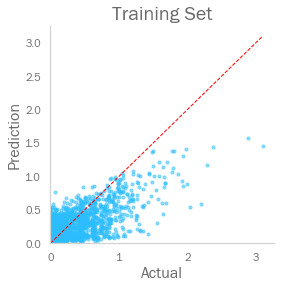

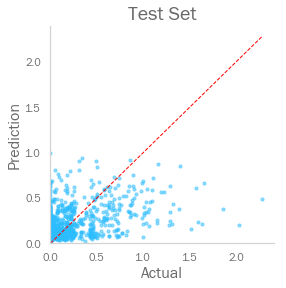

In [47]:
XA_xgb_1 = xgb.XGBRegressor(objective='reg:squarederror')
XA_xgb_1.fit(X_train_XA, y_train_XA)
performance(XA_xgb_1, X_train_XA, X_test_XA, y_train_XA, y_test_XA)


_________R2_________

Train R2: 0.5284
Test R2: 0.1931

Train Adj R2: 0.5165
Test Adj R2: 0.1287

_________MSE________

Train MSE: 0.0485
Test MSE: 0.0813

Train RMSE: 0.2203
Test RMSE: 0.2852


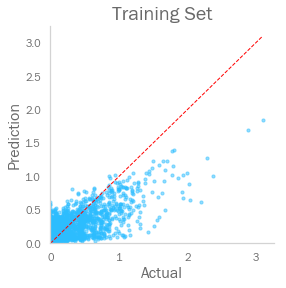

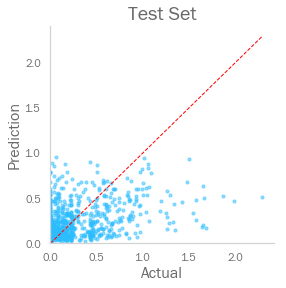

In [48]:
XGI_xgb_1 = xgb.XGBRegressor(objective='reg:squarederror')
XGI_xgb_1.fit(X_train_XGI, y_train_XGI)
performance(XGI_xgb_1, X_train_XGI, X_test_XGI, y_train_XGI, y_test_XGI)

## Gridsearching

Let's try gridsearching to improve the performance.

In [51]:
regressor = xgb.XGBRegressor(objective='reg:squarederror')

#Create a parameter grid, and run it through the GridSearch class
param_grid = {
    "n_estimators" : [50, 100],
    "learning_rate": [0.01, 0.05, 0.2],
    "min_child_weight": [0, 1, 5],
    "max_depth": [3, 6, 10],
    "gamma": [0, 1, 5],
    "subsample": [0.6, 0.8],
    "colsample_bytree ": [0.6, 0.8],
}


XG_xgb_GS = GridSearchCV(regressor, param_grid, cv=4, n_jobs=-1,
                      scoring='neg_mean_squared_error', verbose=3)

XG_xgb_GS.fit(X_train_XG, y_train_XG)

Fitting 4 folds for each of 648 candidates, totalling 2592 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed: 41.9min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 54.2min
[Parallel(n_jobs=-1)]: Done 2592 out of 2592 | elapsed: 54.5min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree ': [0.6, 0.8], 'gamma': [0, 1, 5],
                         'learning_rate': [0.01, 0.05, 0.2],
  

In [52]:
with open('Models/XG_xgb_GS.pickle', 'wb') as f:
    pickle.dump(XG_xgb_GS, f, pickle.HIGHEST_PROTOCOL)

with open('Models/XG_xgb_GS.pickle', 'rb') as f:
    XG_xgb_GS = pickle.load(f)

{'colsample_bytree ': 0.6, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8} 


_________R2_________

Train R2: 0.4351
Test R2: 0.2152

Train Adj R2: 0.4209
Test Adj R2: 0.1525

_________MSE________

Train MSE: 0.0573
Test MSE: 0.0827

Train RMSE: 0.2393
Test RMSE: 0.2877


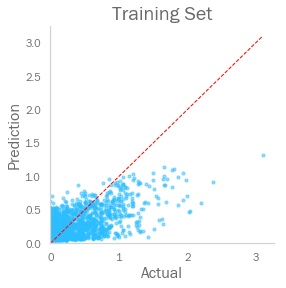

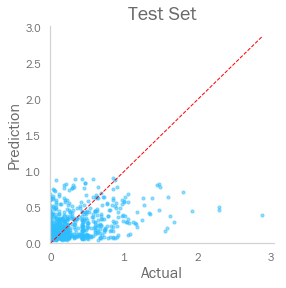

In [53]:
print(XG_xgb_GS.best_params_, '\n')
XG_forest_2 = XG_xgb_GS.best_estimator_
performance(XG_xgb_GS, X_train_XG, X_test_XG, y_train_XG, y_test_XG)

In [54]:
regressor2 = xgb.XGBRegressor(objective='reg:squarederror')

#Create a parameter grid, and run it through the GridSearch class
param_grid = {
    "n_estimators" : [50, 100],
    "learning_rate": [0.01, 0.05, 0.2],
    "min_child_weight": [0, 1, 5],
    "max_depth": [3, 6, 10],
    "gamma": [0, 1, 5],
    "subsample": [0.6, 0.8],
    "colsample_bytree ": [0.6, 0.8],
}


XGI_xgb_GS = GridSearchCV(regressor2, param_grid, cv=4, n_jobs=-1,
                      scoring='neg_mean_squared_error', verbose=3)

XGI_xgb_GS.fit(X_train_XGI, y_train_XGI)

Fitting 4 folds for each of 648 candidates, totalling 2592 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed: 32.0min
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed: 43.8min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 56.3min
[Parallel(n_jobs=-1)]: Done 2592 out of 2592 | elapsed: 56.7min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree ': [0.6, 0.8], 'gamma': [0, 1, 5],
                         'learning_rate': [0.01, 0.05, 0.2],
  

In [55]:
with open('Models/XGI_xgb_GS.pickle', 'wb') as f:
    pickle.dump(XGI_xgb_GS, f, pickle.HIGHEST_PROTOCOL)

with open('Models/XGI_xgb_GS.pickle', 'rb') as f:
    XGI_xgb_GS = pickle.load(f)

{'colsample_bytree ': 0.6, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 0, 'n_estimators': 100, 'subsample': 0.8} 


_________R2_________

Train R2: 0.6045
Test R2: 0.2157

Train Adj R2: 0.5945
Test Adj R2: 0.1531

_________MSE________

Train MSE: 0.0407
Test MSE: 0.079

Train RMSE: 0.2018
Test RMSE: 0.2811


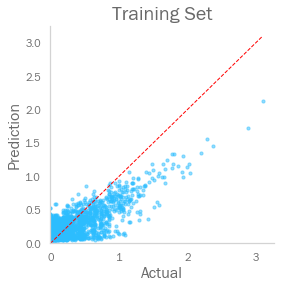

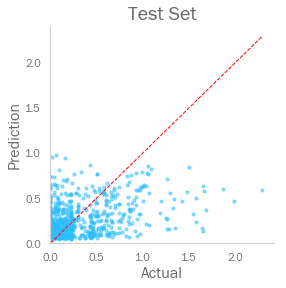

In [56]:
print(XGI_xgb_GS.best_params_, '\n')
XGI_xgb_2 = XGI_xgb_GS.best_estimator_
performance(XGI_xgb_2, X_train_XGI, X_test_XGI, y_train_XGI, y_test_XGI)